In [44]:
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm.notebook import tqdm # Waiting/loading bar for loops

import multiprocess
from functools import partial

In [45]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from stochastic_gradient_descent import * 
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [47]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/01_regression_resampling/img/"

In [48]:
# Data generation
N = 2048
p = 4
sigma = 0.1
x,y,z = random_x_y_franke(N, sigma=sigma)
X = generate_design_matrix(x, y, p)

In [49]:
def relative_error_own_sk(sk_pipeline, sgd_pipeline):
    return np.linalg.norm(sk_pipeline.steps[-1][1].coef_ - sgd_pipeline.steps[-1].betas)/np.linalg.norm(sk_pipeline.steps[-1][1].coef_)
def relative_error_sk(analytical_pipeline, sgd_sk_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_sk_pipeline.steps[-1][1].coef_)/np.linalg.norm(analytical_pipeline.steps[-1].betas)
def relative_error_own(analytical_pipeline, sgd_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_pipeline.steps[-1].betas)/np.linalg.norm(analytical_pipeline.steps[-1].betas)

## Ordinary Least Squares

In [134]:
# Compute "Ground Truth"
ols_pinv = Pipeline([Standardization(), 
                     OrdinaryLeastSquare(solver="pinv")])
ols_pinv.fit(X,z)
error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{OLS}}$"

### Learning Rate Dependency 

In [99]:
minibatches = N
max_epochs = 1000
tol=None

M = 20
lrs_sk = np.logspace(-5,np.log10(0.04),M)

def compute_error(lr):
    # Pipeline using our SGD implmentation
    # Note: The factor of 1/2 in the learning rate to compensate for sklearn's overfall factor of 1/2 in the
    #       squared error cost function entering SGDRegressor. See:
    #       https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, lrs_sk), total=M)
error_to_analytical= list(result)
pool.terminate()

sk_error_to_analytical = np.empty(M)

for i, lr in enumerate(tqdm(lrs_sk)):    
    # Pipeline using sklearn implementations
    ols_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty=None, 
                                                     learning_rate="constant",
                                                     eta0=2*lr,
                                                     max_iter=max_epochs,
                                                     shuffle=True,
                                                     random_state=seed,
                                                     tol=tol))
    
    ols_sk.fit(X,z)
    sk_error_to_analytical[i] = relative_error_sk(ols_pinv, ols_sk)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

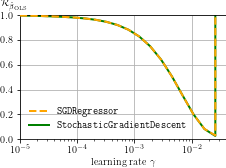

In [100]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)

ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)

ax.plot(lrs_sk, sk_error_to_analytical, label=r"\texttt{SGDRegressor}", c="orange", ls="dashed", zorder=3)
ax.plot(lrs_sk, error_to_analytical, label=r"\texttt{StochasticGradientDescent}", c="green")

ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.04])
ax.set_ylim([0,1])

ax.grid(True)

if save:
    fig.savefig(save_dir + "sgd_ols_learning_rate.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Mini Batches

In [86]:
minibatches = np.power(2,np.arange(12))
max_epochs = 1000
tol=None
lr = 0.02

def compute_error(batches):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=batches,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = minibatches.shape[0]
pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, minibatches), total=M)
error_to_analytical_minibatches = list(result)
pool.terminate()

  0%|          | 0/12 [00:00<?, ?it/s]

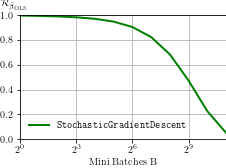

In [87]:
size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)
ax.set_xscale('log', base=2)
ax.set_xlabel(r"Mini Batches B")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)
ax.plot(minibatches, error_to_analytical_minibatches, label=r"\texttt{StochasticGradientDescent}", c="green")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([0,1])
ax.grid(True)

if save:
    fig.savefig(save_dir + "sgd_ols_minibatches.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Epochs

In [116]:
minibatches = [2**8, N]
max_epochs = np.arange(100,12000+100,100)
tol=None
seed=42
lr = 0.02

def compute_error(max_epoch, minibatch):
    
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epoch,
                                             batches=minibatch,
                                             seed=seed,
                                             tol=tol)])
    

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = max_epochs.shape[0]
error_to_analytical_epochs = np.empty((2,M))
pool = multiprocess.Pool()
for j, minibatch in enumerate(tqdm(minibatches)):
    result = pool.map(partial(compute_error, minibatch=minibatch), max_epochs)
    error_to_analytical_epochs[j,:] =  list(result)
pool.terminate()

sk_error_to_analytical_epochs = np.empty(M)
for i, max_epoch in enumerate(tqdm(max_epochs)):
    ols_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty=None, 
                                                         learning_rate="constant",
                                                         eta0=2*lr,
                                                         max_iter=max_epoch,
                                                         shuffle=True,
                                                         random_state=seed,
                                                         tol=tol))
    
    ols_sk.fit(X,z)
    sk_error_to_analytical_epochs[i] = relative_error_sk(ols_pinv, ols_sk)


'\ndef compute_error(max_epoch, minibatch):\n    \n    ols_sgd = Pipeline([Standardization(), \n                         OrdinaryLeastSquare(solver="sgd", \n                                             learning_rate=lambda t, grad: lr,\n                                             max_epochs=max_epoch,\n                                             batches=minibatch,\n                                             seed=seed,\n                                             tol=tol)])\n    \n\n    ols_sgd.fit(X,z)\n    \n    return relative_error_own(ols_pinv, ols_sgd)\n\nM = max_epochs.shape[0]\nerror_to_analytical_epochs = np.empty((2,M))\npool = multiprocess.Pool()\nfor j, minibatch in enumerate(tqdm(minibatches)):\n    result = pool.map(partial(compute_error, minibatch=minibatch), max_epochs)\n    error_to_analytical_epochs[j,:] =  list(result)\npool.terminate()\n\nsk_error_to_analytical_epochs = np.empty(M)\nfor i, max_epoch in enumerate(tqdm(max_epochs)):\n    ols_sk =make_pipeline(Stan

/tmp/ipykernel_19897/2620494804.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


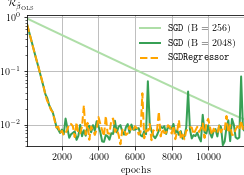

In [120]:
size = (3.9, 0.618 * 3.9) if save else (10,6)
sns.set_palette("Greens",2)
fig,ax = plt.subplots(figsize=size)

ax.set_yscale("log")
max_epochs = np.arange(100,12000+100,100)
ax.set_xlabel(r"epochs")
ax.set_ylabel(error_label, rotation=0)
ax.yaxis.set_label_coords(-0.03,1.03)
for i in range(error_to_analytical_epochs.shape[0]):
    batches = minibatches[i]
    ax.plot(max_epochs, error_to_analytical_epochs[i,:], label=rf"\texttt{{SGD}} (B = {batches})")
ax.plot(max_epochs, sk_error_to_analytical_epochs, label=r"\texttt{SGDRegressor}", c="orange", ls="dashed")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([4e-3,1.1])

plt.draw()
labels = ax.get_xticklabels()
labels[-1] = ""
ax.set_xticklabels(labels)

if save:
    fig.savefig(save_dir + "sgd_ols_epochs.pdf")
else:
    plt.show()

### Adaptive Learning Rate Schedule

In [125]:
eta0 = 0.02
schedules = [Constant(log=True, eta0=eta0), 
             InverseScaling(log=True, eta0=eta0), 
             AdaGrad(log=True, eta0=eta0), 
             RMSProp(log=True, eta0=eta0)]

minibatches = N//4
max_epochs = 1000
tol=None
seed=42

M = len(schedules)
error_to_analytical_schedules = np.empty(M)
for i,schedule in enumerate(tqdm(schedules)):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=schedule,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    error_to_analytical_schedules[i] = relative_error_own(ols_pinv, ols_sgd)

  0%|          | 0/4 [00:00<?, ?it/s]

In [127]:
#Adagrad and RMSProp yield feature-specific learning rates.
#Only show the mean of all

print(schedules[2].learning_rates[0].shape)
schedules[2].learning_rates = np.mean(schedules[2].learning_rates, axis=1)
schedules[3].learning_rates = np.mean(schedules[3].learning_rates, axis=1)

(14,)


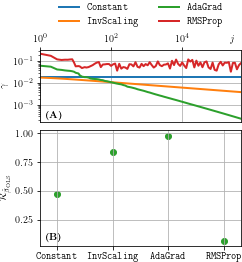

In [137]:
labels = [r"\texttt{Constant}",r"\texttt{InvScaling}",r"\texttt{AdaGrad}",r"\texttt{RMSProp}"]

kwargs = {"height_ratios":[0.618,1]}
size = (3.6, 3.6) if save else (10,6)
sns.set_palette("tab10",4)
fig, ax = plt.subplots(nrows=2, figsize=size, gridspec_kw=kwargs)
plt.subplots_adjust(hspace=0.09)

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top') 
ax[0].set_ylabel(r"$\gamma$")
ax[0].set_xlabel(r"$j$")
ax[0].xaxis.set_label_coords(.95,1.12)
ax[0].text(.03,.05,r"\textbf{(A)}",transform=ax[0].transAxes,c="k")

for label,schedule in zip(labels,schedules):
    lr = np.array(schedule.learning_rates)
    log_idx = np.unique(np.geomspace(1, len(lr), 
                                     num=100, 
                                     endpoint=False).astype(int))
    ax[0].plot(log_idx,lr[log_idx],label=label)
    
ax[1].set_ylabel(error_label)
ax[1].scatter(labels,error_to_analytical_schedules, c="C2")

for a in ax:
    a.legend(*a.get_legend_handles_labels(), 
             ncol=2, 
             bbox_to_anchor=[0.05,1.2],
             loc="lower left")
ax[1].margins(x=0.1) 
ax[1].text(.03,.05,r"\textbf{(B)}",transform=ax[1].transAxes,c="k")

if save:
    fig.savefig(save_dir + "sgd_ols_schedule.pdf", bbox_inches="tight")
else:
    plt.show()

## Ridge Regression

### Learning Rate Dependency 

In [132]:
from functools import partial

minibatches = N
max_epochs = 1000
tol=None
seed=42
M = 20
lrs = np.logspace(-5,np.log10(0.04),M)
penalties=np.hstack((np.logspace(-7,-2,6), np.logspace(-1,2,10)))

def compute_error(lr, penalty):
    # Pipeline using our SGD implmentation
    # Note: 
    #  (i)  The factor of 1/2 in the learning rate to compensate for sklearn's overfall factor of 1/2 in the
    #       squared error cost function *and* the L2 penalty entering SGDRegressor. See:
    #       https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation
    #  (ii) The factor 1/N for the penalties
    ridge_sgd = Pipeline([Standardization(), 
                          RidgeRegression(solver="sgd", 
                                            penalty=penalty/N,
                                            learning_rate=lambda t, grad: lr,
                                            max_epochs=max_epochs,
                                            batches=minibatches,
                                            seed=seed,
                                            tol=tol)])
    ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
    ridge_inv.fit(X,z)
    ridge_sgd.fit(X,z)
    
    return relative_error_own(ridge_inv, ridge_sgd)

pool = multiprocess.Pool()

error_ridge_to_analytical = np.empty((penalties.shape[0],lrs.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    result = pool.map(partial(compute_error, penalty=penalty), lrs)
    error_ridge_to_analytical[j,:] =  list(result)

sk_error_ridge_to_analytical = np.empty((penalties.shape[0],lrs.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    for i, lr in enumerate(lrs): 
        ridge_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty="l2", 
                                                             alpha=penalty/N,
                                                             learning_rate="constant",
                                                             eta0=2*lr,
                                                             max_iter=max_epochs,
                                                             shuffle=True,
                                                             random_state=seed,
                                                             tol=tol))
        ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
        ridge_inv.fit(X,z)
        ridge_sk.fit(X,z)
        sk_error_ridge_to_analytical[j,i] = relative_error_sk(ridge_inv, ridge_sk)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

4.6415888336127775


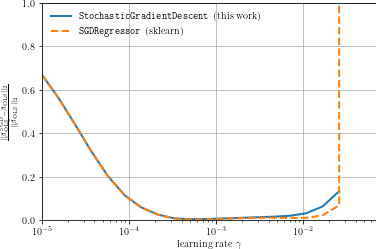

In [150]:
fig, ax = plt.subplots()
i=-5
print(penalties[i])
ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(lrs, error_ridge_to_analytical[i,:], label=r"\texttt{StochasticGradientDescent} (this work)")
ax.plot(lrs, sk_error_ridge_to_analytical[i,:], ls="dashed", label=r"\texttt{SGDRegressor} (sklearn)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.07])
ax.set_ylim([0,1])
plt.show()

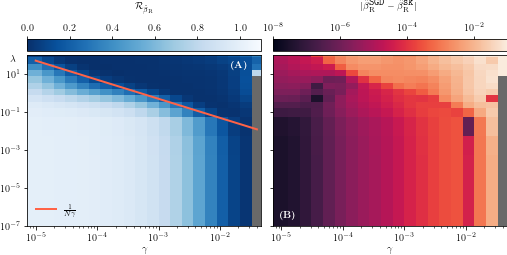

In [170]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{R}}$"
cmap = sns.color_palette("Blues_r", as_cmap=True).copy()
cmap.set_bad("dimgray")
kwargs = { 
          "cmap":cmap,
          "shading":"nearest",
          "vmin":0,
          "vmax":1.1,
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

fig, ax = plt.subplots(figsize=(8.6,8.6*0.4), ncols=2, sharey=True)
for a in ax:
    a.grid(False)
    a.set_yscale("log")
    a.set_xscale("log")
    a.set_xlabel(r'$\gamma$')
    a.set_ylim([penalties[0],penalties[-1]])

masked_error_ridge_to_analytical = error_ridge_to_analytical
masked_error_ridge_to_analytical[error_ridge_to_analytical>1] = np.nan

im = ax[0].pcolormesh(lrs, penalties, masked_error_ridge_to_analytical, **kwargs)
ax[0].plot(lrs, 1/(N*lrs), c="tomato", label=r"$\frac{1}{N\gamma}$")
ax[0].legend(*ax[0].get_legend_handles_labels(), loc="lower left")
ax[0].set_ylabel(r'$\lambda$', rotation=0)
ax[0].yaxis.set_label_coords(-0.06,.95)
ax[0].text(.87,.92,r"\textbf{(A)}",transform=ax[0].transAxes,c="w")

ax_divider = make_axes_locatable(ax[0])
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cax.grid(False)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(error_label)
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,3.5)

residual = np.abs(error_ridge_to_analytical - sk_error_ridge_to_analytical)
del kwargs["vmin"]
del kwargs["vmax"]
residual_cmap = sns.color_palette("rocket", as_cmap=True).copy()
residual_cmap.set_bad("dimgray")
kwargs["cmap"] = residual_cmap
kwargs["norm"] = colors.LogNorm(vmin=1e-8, 
                                vmax=.1)

im = ax[1].pcolormesh(lrs, penalties, residual, **kwargs)
ax_divider = make_axes_locatable(ax[1])
cax2 = ax_divider.append_axes("top", size="7%", pad="2%")
cax2.grid(False)
cb = fig.colorbar(im, cax=cax2, orientation="horizontal")
cax2.xaxis.set_ticks_position("top")
cax2.set_xlabel(r"$|\hat\beta_\mathrm{R}^\texttt{SGD}-\hat\beta_\mathrm{R}^{\texttt{sk}}|$")
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_label_coords(0.5,3.5)
ax[1].text(.03,.05,r"\textbf{(B)}",transform=ax[1].transAxes,c="w")

plt.subplots_adjust(wspace=0.05)

if save:
    fig.savefig(save_dir + "sgd_ridge_learning_rate.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Mini Batches

In [166]:
penalties=np.hstack((np.logspace(-7,-2,6), np.logspace(-1,2,10)))
minibatches = np.power(2,np.arange(12))
max_epochs = 1000
tol=None
seed=42
lr = 0.02

def compute_error(minibatch_number, penalty):
    # Pipeline using our SGD implmentation
    # Note: 
    #  (ii) The factor 1/N for the penalties
    ridge_sgd = Pipeline([Standardization(), 
                          RidgeRegression(solver="sgd", 
                                            penalty=penalty/minibatch_number,
                                            learning_rate=lambda t, grad: lr,
                                            max_epochs=max_epochs,
                                            batches=minibatch_number,
                                            seed=seed,
                                            tol=tol)])
    ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
    ridge_inv.fit(X,z)
    ridge_sgd.fit(X,z)
    
    return relative_error_own(ridge_inv, ridge_sgd)

pool = multiprocess.Pool()

error_ridge_to_analytical_minibatches = np.empty((penalties.shape[0],minibatches.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    result = pool.map(partial(compute_error, penalty=penalty), minibatches)
    error_ridge_to_analytical_minibatches[j,:] =  list(result)

  0%|          | 0/16 [00:00<?, ?it/s]

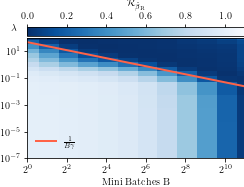

In [169]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{R}}$"
cmap = sns.color_palette("Blues_r", as_cmap=True).copy()
cmap.set_bad("dimgray")
kwargs = { 
          "cmap":cmap,
          "shading":"nearest",
          "vmin":0,
          "vmax":1.1,
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

fig, ax = plt.subplots(figsize=(3.9,3.9*0.618))
ax.grid(False)
ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.set_xlabel(r'Mini Batches B')
ax.set_ylabel(r'$\lambda$', rotation=0)
ax.yaxis.set_label_coords(-0.06,1.05)
ax.set_ylim([penalties[0],penalties[-1]])
ax.set_xlim([minibatches[0], minibatches[-1]])

im = ax.pcolormesh(minibatches, penalties, error_ridge_to_analytical_minibatches, **kwargs)
ax.plot(minibatches, 1/(minibatches*lr), c="tomato", label=r"$\frac{1}{B\gamma}$")
ax.legend(*ax.get_legend_handles_labels(), loc="lower left")

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cax.grid(False)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(error_label)
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,3.5)

if save:
    fig.savefig(save_dir + "sgd_ridge_minibatches.pdf", bbox_inches="tight")
else:
    plt.show()

### Dependence on the Number of Epochs

In [188]:
from functools import partial

penalties=np.hstack((np.logspace(-7,-2,6), np.logspace(-1,2,10)))
minibatches = 2**8
max_epochs = np.arange(0,11000,1000); max_epochs[0]=100
tol=None
seed=42
lr = 0.02

def compute_error(max_epoch, penalty):
    # Pipeline using our SGD implmentation
    # Note: 
    #  (ii) The factor 1/N for the penalties
    ridge_sgd = Pipeline([Standardization(), 
                          RidgeRegression(solver="sgd", 
                                            penalty=penalty/minibatches,
                                            learning_rate=lambda t, grad: lr,
                                            max_epochs=max_epoch,
                                            batches=minibatches,
                                            seed=seed,
                                            tol=tol)])
    ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
    ridge_inv.fit(X,z)
    ridge_sgd.fit(X,z)
    
    return relative_error_own(ridge_inv, ridge_sgd)

pool = multiprocess.Pool()

error_ridge_to_analytical_epoch = np.empty((penalties.shape[0],max_epochs.shape[0]))

for j, penalty in enumerate(tqdm(penalties)):
    result = pool.map(partial(compute_error, penalty=penalty), max_epochs)
    error_ridge_to_analytical_epoch[j,:] =  list(result)


  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_19897/2557530048.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


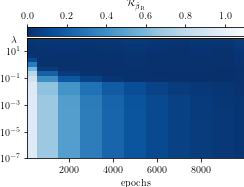

In [189]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

error_label = r"$\mathcal{R}_{\hat{\beta}_\mathrm{R}}$"
cmap = sns.color_palette("Blues_r", as_cmap=True).copy()
cmap.set_bad("dimgray")
kwargs = { 
          "cmap":cmap,
          "shading":"nearest",
          "vmin":0,
          "vmax":1.1,
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

fig, ax = plt.subplots(figsize=(3.9,3.9*0.618))
ax.grid(False)
ax.set_yscale("log")
#ax.set_xscale("log", base=2)
ax.set_xlabel(r'epochs')
ax.set_ylabel(r'$\lambda$', rotation=0)
ax.yaxis.set_label_coords(-0.06,.95)
ax.set_ylim([penalties[0],penalties[-1]])
ax.set_xlim([max_epochs[0], max_epochs[-1]])

im = ax.pcolormesh(max_epochs, penalties, error_ridge_to_analytical_epoch, **kwargs)
#ax.plot(minibatches, 1/(2*minibatches*lr), c="tomato", label=r"$\frac{1}{2B\gamma}$")
#ax.legend(*ax.get_legend_handles_labels(), loc="lower left")

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cax.grid(False)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(error_label)
cax.xaxis.set_label_position('top')
cax.xaxis.set_label_coords(0.5,3.5)

plt.draw()
labels = ax.get_xticklabels()
labels[-1] = ""
ax.set_xticklabels(labels)
    
if save:
    fig.savefig(save_dir + "sgd_ridge_epochs.pdf", bbox_inches="tight")
else:
    plt.show()

### Adaptive Learning Rate Schedule

In [171]:
eta0 = 0.02

schedules = [Constant(log=True, eta0=eta0),
             InverseScaling(log=True, eta0=eta0), 
             AdaGrad(log=True, eta0=eta0), 
             RMSProp(log=True, eta0=eta0)]

penalties=np.hstack((np.logspace(-7,-4,4), np.logspace(-3,2,28)))
minibatches = N//4
max_epochs = 2000
tol=None
seed=42
lr = 0.02

def compute_error(schedule, penalty):
    ridge_sgd = Pipeline([Standardization(), 
                          RidgeRegression(solver="sgd", 
                                            penalty=penalty/minibatches,
                                            learning_rate=schedule,
                                            max_epochs=max_epochs,
                                            batches=minibatches,
                                            seed=seed,
                                            tol=tol)])
    ridge_inv = Pipeline([Standardization(), 
                     RidgeRegression(penalty=penalty, solver="inv")])
    
    ridge_inv.fit(X,z)
    ridge_sgd.fit(X,z)
    
    return relative_error_own(ridge_inv, ridge_sgd), schedule

pool = multiprocess.Pool()

error_ridge_to_analytical_schedules = np.empty((penalties.shape[0],len(schedules)))
used_schedules = np.empty((penalties.shape[0],len(schedules)), dtype=object)

for j, penalty in enumerate(tqdm(penalties)):
    result,used_schedule = zip(*pool.map(partial(compute_error, penalty=penalty), schedules))
    error_ridge_to_analytical_schedules[j,:] = list(result)
    used_schedules[j,:] = list(used_schedule)


  0%|          | 0/32 [00:00<?, ?it/s]

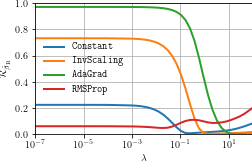

In [184]:
labels = [r"\texttt{Constant}",r"\texttt{InvScaling}",r"\texttt{AdaGrad}",r"\texttt{RMSProp}"]

fig, ax = plt.subplots(figsize=(3.9,3.9*0.618))

for i, label in enumerate(labels):
    ax.plot(penalties, error_ridge_to_analytical_schedules[:,i], label=label)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(error_label)
ax.set_ylim([0,1])

ax.legend(*ax.get_legend_handles_labels())

if save:
    fig.savefig(save_dir + "sgd_ridge_schedule.pdf", bbox_inches="tight")
else:
    plt.show()

## Profiling the mess we created

In [51]:
from line_profiler import LineProfiler

minibatches = N
max_epochs = 100
tol=None
seed=42
lr = 1e-5
profile=True

ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=Constant(eta0=lr),
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

if profile:
    lp = LineProfiler()
    lp.add_function(OrdinaryLeastSquare.gradient_loss)
    lp.add_function(StochasticGradientDescent.minimize)
    lp.add_function(OrdinaryLeastSquare.fit)
    lp_wrapper=lp(ols_sgd.fit)
    lp_wrapper(X,z)
    lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.56578 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: gradient_loss at line 60

Line #      Hits         Time  Per Hit   % Time  Line Contents
    60                                               def gradient_loss(self, X, y, p):
    61    204800     555739.0      2.7     35.5          y_pred = X @ p
    62    204800    1010040.0      4.9     64.5          return 2 * X.T @ (y_pred - y)

Total time: 7.03604 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: fit at line 64

Line #      Hits         Time  Per Hit   % Time  Line Contents
    64                                               def fit(self, X, y):
    65                                           
    66         1        245.0    245.0      0.0          X, X_mean, y, y_mean = self._center_data(X, y)
    67                                           
